This tutorial demonstrates how to classify a highly imbalanced data in which the number of examples in a one class grealy outnumbers the examples in another. You will work with the [Credit Card Fraud Detection Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) hosted on the kaggle.

You are trying to detect 492 fraudulent transactions from 284,807 transactions in total. In this tutorial, you are going to build a model with the help of class weights to learn from the imbalanced data.

In general, the following are common techniques to deal with the imbalanced data.
* Class Weighting
* Oversampleing

In [0]:
!pip uninstall -y tensorflow  # remove the default tensorflow
!pip install -q tf-nightly sklearn

In [1]:
import tensorflow as tf
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200318
GPU is available.


In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Data Preprocessing and Exploration

## Download the Kaggle Credit Card Fraud Dataset

In [4]:
raw_df = pd.read_csv(
  filepath_or_buffer='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Examine the class label imbalance

Look at the imbalanced dataset.

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print("Total {}, Pos. Count {} and Ratio {:.2f}%".format(total, pos, (pos / total) * 100))

Total 284807, Pos. Count 492 and Ratio 0.17%


## Clean, Split, and Normalize the Data

In [0]:
cleaned_df = raw_df.copy()

# you don't need the `Time` Column
cleaned_df.pop('Time')

# The `Amount` column covers a huge range.
# Convert to the log space.
eps = 1e-3  # avoid 0.0, 0.0 => 
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

Split the dataset into the training, testing, and validation datasets.

In [8]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
type(val_df)

pandas.core.frame.DataFrame

Form numpy arrays of labels and features.

In [0]:
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
val_features.shape, val_features[:1,:]

((45569, 29),
 array([[-1.47760136,  1.50485241,  0.65655096,  1.2941012 , -0.63595095,
          0.148272  , -0.1740107 ,  1.11203258, -0.63294914, -0.07180714,
          0.90290038,  0.96642328, -0.66228655,  0.89185791, -0.49129594,
         -0.8183953 ,  0.80817772, -0.12908092,  0.89952487, -0.00676966,
          0.06827329,  0.32398818, -0.0555326 ,  0.22367308, -0.07600722,
         -0.24167707,  0.32194851,  0.08200606,  3.66512453]]))

Normalize the input features using the Sklearn StandardScaler to normalize the value that the mean is `0` and the standard deviation is `1`. Normalize along the feature dimension space (by columns).

Second, remove the outliner using `clip`.

In [0]:
scaler = StandardScaler()

# normalize the features
train_features = scaler.fit_transform(X=train_features)
val_features = scaler.fit_transform(X=val_features)
test_features = scaler.fit_transform(X=test_features)

# remove the outliner
train_features = np.clip(train_features, a_min=-5, a_max=5)
val_features = np.clip(val_features, a_min=-5, a_max=5)
test_features = np.clip(test_features, a_min=-5, a_max=5)

In [12]:
val_features[:1, :]

array([[-0.76204124,  0.91410177,  0.42841297,  0.91374309, -0.47351179,
         0.11256248, -0.14492558,  0.97274352, -0.57862367, -0.0657021 ,
         0.89001582,  0.96416777, -0.66755172,  0.93261873, -0.54136969,
        -0.9342987 ,  0.94073267, -0.14994867,  1.09915188, -0.00607635,
         0.10268388,  0.45219409, -0.07043574,  0.37323665, -0.14665639,
        -0.49961872,  0.79244208,  0.24026357,  0.36334872]])

In [13]:
print('Training labels shape: {}'.format(train_labels.shape))
print("Validation labels shape: {}".format(val_labels.shape))
print("Testing labels shape: {}".format(test_labels.shape))

print("Training features shape: {}".format(train_features.shape))
print("Validation features shape: {}".format(val_features.shape))
print("Testing features shape: {}".format(test_features.shape))

Training labels shape: (182276,)
Validation labels shape: (45569,)
Testing labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Testing features shape: (56962, 29)


## Look at the Data Distribution

Next, compare the distribution between the positive and the negative examples over a few features. Following are few viewpoints:

* Do these distributions make senses?
* Can you see the difference between the distributions?

In [0]:
pos_df = pd.DataFrame(data=train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(data=train_features[~bool_train_labels], columns=train_df.columns)

Text(0.5, 0.98, 'Positive Distribution')

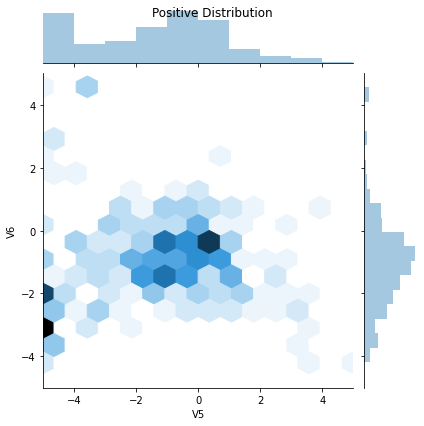

In [15]:
sns.jointplot(x=pos_df['V5'], y=pos_df['V6'], 
              kind='hex', xlim=[-5,5], ylim=[-5,5])
plt.suptitle('Positive Distribution')

Text(0.5, 0.98, 'Negative Distribution')

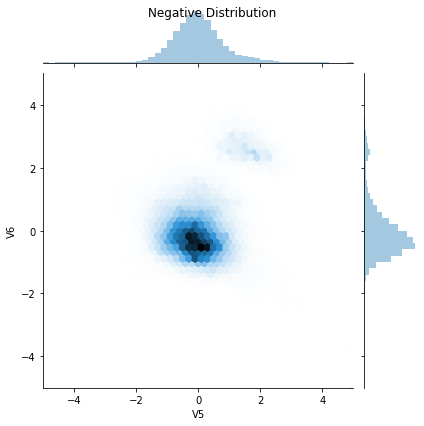

In [16]:
sns.jointplot(x=neg_df['V5'], y=neg_df['V6'], kind='hex', 
              xlim=[-5,5], ylim=[-5,5])
plt.suptitle('Negative Distribution')

# Define the Model and the Metrics

About the metrics:

* `True Positives` and `True Negatives` are examples that were correctly classified
* `False Positives` and `False Negatives` are examples that were incorrectly classified
* `Accuracy` is the precentage of examples that were correctly classified. $\frac{True\ Positives+True\ Negatives}{Total\ samples}$
* `Precision` is the percentage of predicted examples that were correctly classified. $\frac{True\ Positives}{True\ Positives+False\ Positives}$
* `Recall`, a.k.a. `Sensitivity`, is the precentage of true examples that were correctly predicted. $\frac{True\ Positives}{True\ Positives+False\ Negatives}$
* `AUC` is the area under the curve of Receiver Operating Characteristic Curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.

In [0]:
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'),
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='percision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')
]

In [0]:
def build_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(value=output_bias)
  
  def _model(inputs):
    x = tf.keras.layers.Dense(units=16, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    prob = tf.keras.layers.Dense(units=1, activation='sigmoid', 
                                 bias_initializer=output_bias)(x)
    return prob
  
  inputs = tf.keras.Input(shape=(train_features.shape[-1], ))
  outputs = _model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=metrics
  )
  return model

# Baseline Model

## Build the Model

Notice each batch must have a decent chance of containing a few positive samples. If the batch size is too small, the batch would probably have no fraudulent transactions to learn from.

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_auc', verbose=1, patience=10, mode='max', restore_best_weights=True
)

In [20]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Run the model.

In [21]:
model.predict(train_features[:10])

array([[0.20420463],
       [0.27226916],
       [0.17816898],
       [0.32714817],
       [0.69555146],
       [0.03711061],
       [0.4150433 ],
       [0.10481083],
       [0.12358614],
       [0.26342157]], dtype=float32)

## Set the correct initial bias (Optional)

These initial predictions are understandable. However, they are not great. You know these are imbalanced datasets. The predictions should be gathered to the subset that the most elements belong to. Now, this outcome is different from the prediction.

We are going to set the output layer's bias to reflact the outcome. This can help with the initial convergence.

In [22]:
results = model.evaluate(x=train_features, y=train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:.4f}".format(results[0]))

Loss: 0.3398


The correct bias to be set is derived from:

$$p_0 = \frac{pos}{pos + neg} = \frac{1}{1 + e^{-b_0}}$$
$$p_0 + p_0e^{-b_0} = 1$$
$$e^{-b_0} = \frac{1 - p_0}{p_0}$$
$$log_e{e^{-b_0}}=log_e{\frac{1 - p_0}{p_0}}$$
$$-b_0=log_e\frac{neg}{pos}$$
$$b_0=log_e{\frac{pos}{neg}}$$

In [23]:
initial_bias = np.log([pos / neg])
initial_bias, pos / (pos + neg)

(array([-6.35935934]), 0.001727485630620034)

Set this value as the initial bias to see whether the output of the model is more reasonable. It should be near `pos/total = 0.0018`. 

In [0]:
model = build_model(output_bias=initial_bias)

In [25]:
model.predict(train_features[:10])

array([[0.00150714],
       [0.00260496],
       [0.00104932],
       [0.00092553],
       [0.00046384],
       [0.00017974],
       [0.00260226],
       [0.00061101],
       [0.00056102],
       [0.00114533]], dtype=float32)

With this initialization the initial binary cross entropy loss should be near:

$$-p_0log(p_0) - (1-p_0)log(1-p_0) \approx 0.013174$$

In [26]:
-0.0018 * np.log(0.0018) - (1-0.0018)*np.log(1-0.0018)

0.01317432253246831

In [27]:
results = model.evaluate(x=train_features, y=train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Adjusted Loss: {:.4f}".format(results[0]))

Adjusted Loss: 0.0189


Such a loss value is about 50 times less than the naive initialization.

## Checkpoint the initial weights

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(), "initial_weights")
model.save_weights(initial_weights)

## Confirm that the bias fix helps

Let's train the model for 20 epochs and compare the model between the zero bias and the initialization bias.

In [0]:
model = build_model()
model.load_weights(initial_weights)

# reassign the bias of the last layer
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(x=train_features, 
          y=train_labels, 
          batch_size=BATCH_SIZE,
          epochs=20, 
          validation_data=(val_features, val_labels),
          verbose=0)

In [0]:
model = build_model()
model.load_weights(initial_weights)

init_bias_history = model.fit(x=train_features, 
          y=train_labels, 
          batch_size=BATCH_SIZE, 
          epochs=20, 
          verbose=0, 
          validation_data=(val_features, val_labels))

In [31]:
init_bias_history.history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'percision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_percision', 'val_recall', 'val_auc'])

In [0]:
def plot_history(history, label, col):
  plt.semilogy(history.epoch, history.history['loss'], 
               color=colors[col], label="Train " + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[col], label="Val " + label, linestyle="--")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")

  plt.legend()

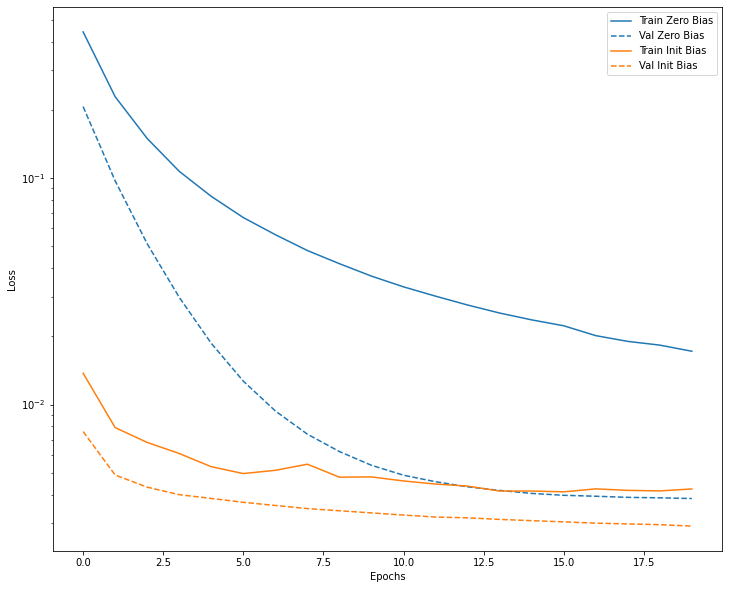

In [33]:
plot_history(zero_bias_history, "Zero Bias", 0)
plot_history(init_bias_history, "Init Bias", 1)
plt.show()

## Train the Model

In [34]:
model = build_model()
model.load_weights(initial_weights)

baseline_history = model.fit(x=train_features, 
                             y=train_labels, 
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, 
                             callbacks=[early_stopping], 
                             validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 17ms/step - loss: 0.0136 - tp: 72.0000 - fp: 10.0000 - tn: 227439.0000 - fn: 324.0000 - accuracy: 0.9985 - percision: 0.8780 - recall: 0.1818 - auc: 0.6865 - val_loss: 0.0085 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45489.0000 - val_fn: 80.0000 - val_accuracy: 0.9982 - val_percision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8741
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 0.0083 - tp: 90.0000 - fp: 24.0000 - tn: 181936.0000 - fn: 226.0000 - accuracy: 0.9986 - percision: 0.7895 - recall: 0.2848 - auc: 0.8124 - val_loss: 0.0050 - val_tp: 33.0000 - val_fp: 5.0000 - val_tn: 45484.0000 - val_fn: 47.0000 - val_accuracy: 0.9989 - val_percision: 0.8684 - val_recall: 0.4125 - val_auc: 0.9123
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0062 - tp: 144.0000 - fp: 20.0000 - tn: 181940.0000 - fn: 172.0000 - accuracy: 0.9989 - percision: 0.8780 - recall: 0.4557 - auc:

## Check training history

In [35]:
baseline_history.history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'percision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_percision', 'val_recall', 'val_auc'])

In [0]:
def plot_metrics(history):
  metrics = ["loss", "auc", "percision", "recall"]
  for n, met in enumerate(metrics):
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch, history.history[met], 
             color=colors[0], label='Train')
    plt.plot(history.epoch, history.history["val_" + met], 
             color=colors[0], label="Val", linestyle="--")
    
    name = met.capitalize()
    plt.xlabel('Epochs')
    plt.ylabel(name)

    if met == "loss":
      plt.ylim([0, history.history["loss"][0]])
    elif met == "auc":
      plt.ylim([0.8, 1.0])
    else:
      plt.ylim([0, 1])
    
    plt.legend()
  plt.show()

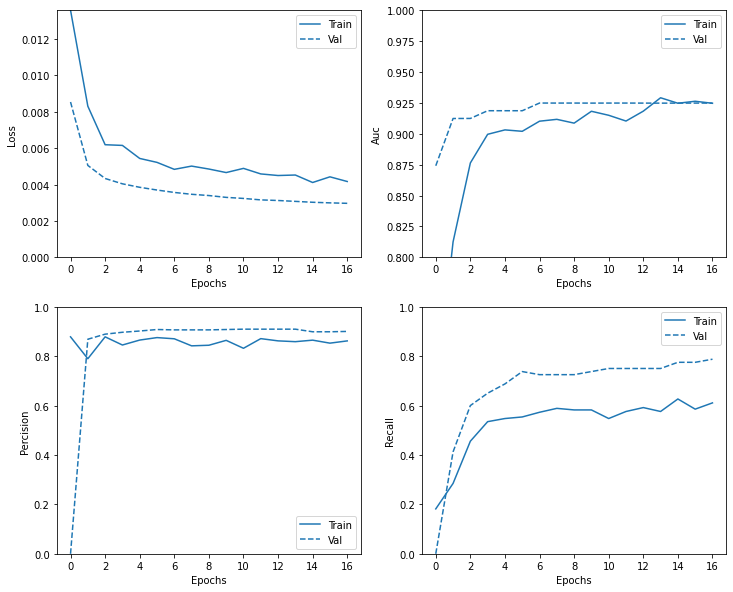

In [37]:
plot_metrics(baseline_history)

## Evaluate Metrics

You can use a confusion matrix to summarize the true vs. predicted label where the Y axis is the actual label and the X axis is the predicted label.

In [0]:
def plot_cm(labels, predictions, p=0.5):
  # cm[0]: Predicted Negatives
  # cm[1]: Predicted Positives
  cm = confusion_matrix(y_true=labels, y_pred=(predictions > p))
  
  plt.figure(figsize=(5, 5))
  sns.heatmap(data=cm, annot=True, fmt='d')
  plt.title('Confusion Matrix @{:.1f}'.format(p))
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

  print('Legitimate Transactions Detected (True Negatives):', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives):', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives):', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives):', cm[1][1])
  print('Total Fraudulent Transactions:', np.sum(cm[1]))

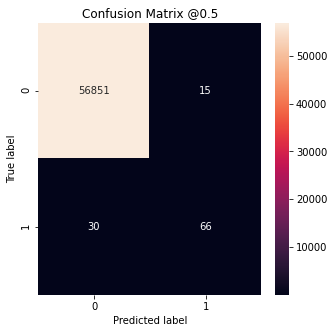

Legitimate Transactions Detected (True Negatives): 56851
Legitimate Transactions Incorrectly Detected (False Positives): 15
Fraudulent Transactions Missed (False Negatives): 30
Fraudulent Transactions Detected (True Positives): 66
Total Fraudulent Transactions: 96


In [39]:
test_prediction_baseline = model.predict(x=test_features, batch_size=BATCH_SIZE)
plot_cm(labels=test_labels, predictions=test_prediction_baseline)

False negatives and false positives are a trade-off problem. If you try to minimize the false negatives, you might encounter the increase of false positives. False negatives would allow fraudulent transactions to continue. False positives cause more operations took to ask the customers for more verification.

## Plot the ROC

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
  plt.xlabel('False Positives [%]')
  plt.ylabel('True Positives [%]')
  plt.xlim([-0.5, 20.])
  plt.ylim([80., 100.0])
  plt.grid(True)
  ax = plt.gca()  # gca: get current axes
  ax.set_aspect('equal')

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)

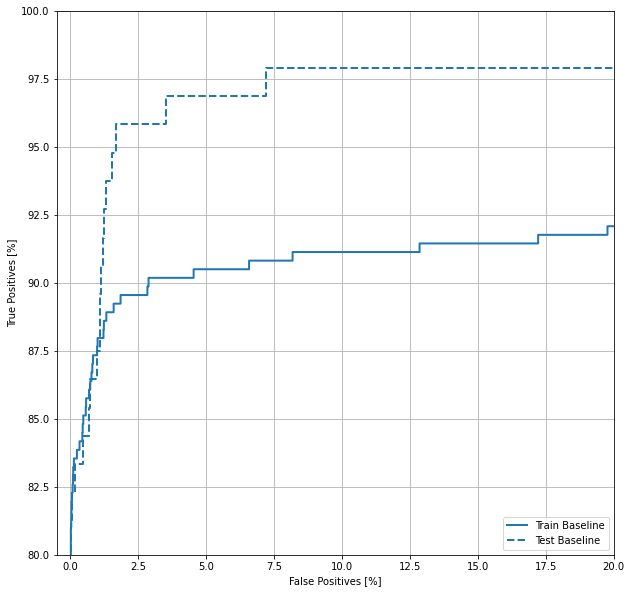

In [42]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_prediction_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')
plt.show()

# Class Weights

## Calculate Class Weights

The goal is to find the fraudulent transactions, but the datasets contain not many positive examples. You would want to have the classifier heavily weight the few examples that are positive. You can pass the weights for each class to tell the model pay more attentions to the examples from an under-represented class.

In [49]:
# scaling by total/2.0 helps keep the loss to a similar magnitude
# the sum of the weights of all examples stays the same
weight_for_neg = (1.0 / neg) * (total / 2.0)
weight_for_pos = (1.0 / pos) * (total / 2.0)

class_weight = {0: weight_for_neg, 1: weight_for_pos}

print('Weight for Neg. Samples: {:.2f}'.format(weight_for_neg))
print('Weight for Pos. Samples: {:.2f}'.format(weight_for_pos))

Weight for Neg. Samples: 0.50
Weight for Pos. Samples: 289.44


## Train a Model with Class Weights

Next, try training a new model with the help of class weights, and look at the effects on the predictions.

**Using `class weights` changes the range of the loss. This may cause the instability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers, `SGD`, may fail. We suggest using `Adam` that is not affected by the scaling change. Remember, the total losses are not comparable between models above because of the weighting.**

In [50]:
weighted_model = build_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
  x=train_features, 
  y=train_labels, 
  batch_size=BATCH_SIZE, 
  epochs=EPOCHS, 
  callbacks=[early_stopping], 
  validation_data=(val_features, val_labels), 
  # use the class weights
  class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 2s 18ms/step - loss: 3.1340 - tp: 107.0000 - fp: 13483.0000 - tn: 213966.0000 - fn: 289.0000 - accuracy: 0.9396 - percision: 0.0079 - recall: 0.2702 - auc: 0.6356 - val_loss: 0.0074 - val_tp: 20.0000 - val_fp: 4.0000 - val_tn: 45485.0000 - val_fn: 60.0000 - val_accuracy: 0.9986 - val_percision: 0.8333 - val_recall: 0.2500 - val_auc: 0.9024
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 1.2077 - tp: 141.0000 - fp: 142.0000 - tn: 181818.0000 - fn: 175.0000 - accuracy: 0.9983 - percision: 0.4982 - recall: 0.4462 - auc: 0.8593 - val_loss: 0.0074 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45481.0000 - val_fn: 18.0000 - val_accuracy: 0.9994 - val_percision: 0.8857 - val_recall: 0.7750 - val_auc: 0.9293
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 0.7384 - tp: 207.0000 - fp: 378.0000 - tn: 181582.0000 - fn: 109.0000 - accuracy: 0.9973 - percision: 0.3538 - recall: 0.6551 - auc: 0.8950 

## Check training history

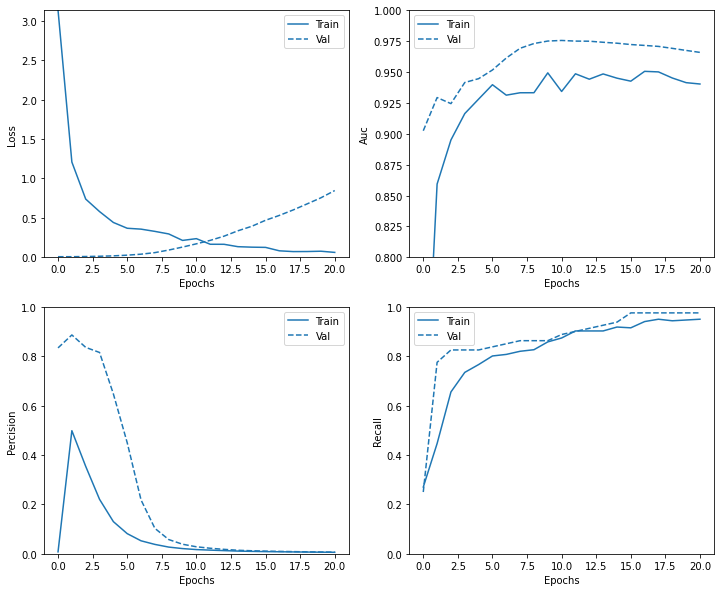

In [51]:
plot_metrics(weighted_history)

## Evaluate Metrics

In [0]:
test_prediction_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

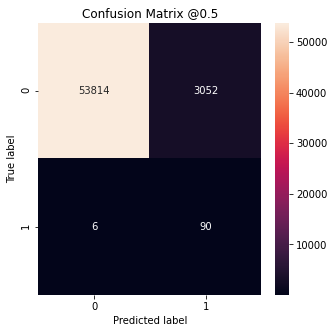

Legitimate Transactions Detected (True Negatives): 53814
Legitimate Transactions Incorrectly Detected (False Positives): 3052
Fraudulent Transactions Missed (False Negatives): 6
Fraudulent Transactions Detected (True Positives): 90
Total Fraudulent Transactions: 96


In [53]:
plot_cm(labels=test_labels, predictions=test_prediction_weighted)

## Plot the ROC

In [0]:
train_predictions_weighted = weighted_model.predict(x=train_features, batch_size=BATCH_SIZE)

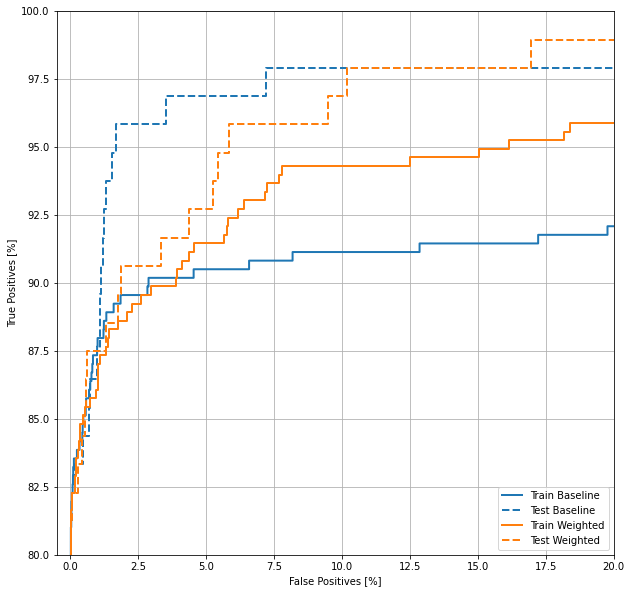

In [55]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_prediction_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_prediction_weighted, color=colors[1], linestyle="--")

plt.legend(loc='lower right')
plt.show()

# Oversampling

## Oversample the minority class

A related approach is to resample the dataset by oversampling the minority class.

In [58]:
# the positive samples
np.where(bool_train_labels)

(array([   652,    879,   2977,   4923,   5485,   5628,   6587,   7897,
          7959,   8123,   9080,  12075,  12338,  13187,  13912,  15715,
         16036,  16792,  17219,  17746,  17881,  18519,  18823,  19109,
         21105,  21756,  22039,  22361,  22439,  22504,  22647,  23231,
         23620,  23751,  23924,  24666,  25080,  25442,  25765,  25829,
         26169,  26425,  26863,  27027,  27449,  27844,  27964,  28094,
         28506,  28932,  29688,  30192,  30875,  31278,  31377,  31686,
         32224,  32335,  32987,  33113,  33289,  33619,  33977,  34781,
         34961,  38501,  39092,  39224,  39665,  40199,  40618,  41185,
         42189,  42328,  42457,  43791,  44170,  44409,  44539,  45009,
         47783,  48722,  48857,  50296,  52087,  52228,  52938,  53148,
         53476,  54411,  55421,  55927,  56695,  57526,  58079,  58624,
         59107,  59460,  59553,  60377,  60402,  60490,  60555,  60622,
         60626,  60730,  60832,  61135,  61252,  61319,  61817, 

In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

You can balance the dataset manually by generating the same size with negative samples.

In [62]:
ids = np.arange(len(pos_features))
choices = np.random.choice(a=ids, size=len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181960, 29)

Concatenate the positive and negative samples and then shuffle them for a new dataset.

In [65]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)  # shuffle the order
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363920, 29)

## Create a new data input pipeline using `tf.data`.

You can also use the `tf.data` APIs to generate the dataset pipeline with a proper ratio of imbalanced datasets.

In [0]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(features=pos_features, labels=pos_labels)
neg_ds = make_ds(features=neg_features, labels=neg_labels)

In [68]:
for features, labels in pos_ds.take(1):
  print(features.shape, labels.numpy())

(29,) 1


Merge these two datasets use `tf.data.experimental.sample_from_datasets` and pass a weighted list.

In [0]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [71]:
for features, labels in resampled_ds.take(1):
  print(np.mean(labels.numpy()))

0.5087890625


To use this resampled dataset, you'll need the number of steps per epoch (You have set the `repeat()` to the dataset). The number of batches is to see each negative example once.

In [73]:
resampled_steps_per_epoch = np.ceil(2 * neg / BATCH_SIZE)
resampled_steps_per_epoch

278.0

## Train on the Oversampled Data

In [0]:
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

In [76]:
resampled_model = build_model()
resampled_model.load_weights(filepath=initial_weights)

# no imblanced data existing
resampled_model.layers[-1].bias.assign([0.0])

resampled_history = resampled_model.fit(
  resampled_ds, 
  epochs=EPOCHS, 
  callbacks=[early_stopping], 
  validation_data=val_ds, 
  steps_per_epoch=resampled_steps_per_epoch
)

Epoch 1/100
278/278 [==============================] - 7s 23ms/step - loss: 0.5722 - tp: 218341.0000 - fp: 85495.0000 - tn: 245882.0000 - fn: 65195.0000 - accuracy: 0.7549 - percision: 0.7186 - recall: 0.7701 - auc: 0.8251 - val_loss: 0.2468 - val_tp: 68.0000 - val_fp: 914.0000 - val_tn: 44575.0000 - val_fn: 12.0000 - val_accuracy: 0.9797 - val_percision: 0.0692 - val_recall: 0.8500 - val_auc: 0.9377
Epoch 2/100
278/278 [==============================] - 6s 20ms/step - loss: 0.2415 - tp: 251927.0000 - fp: 20810.0000 - tn: 264112.0000 - fn: 32495.0000 - accuracy: 0.9064 - percision: 0.9237 - recall: 0.8858 - auc: 0.9587 - val_loss: 0.1392 - val_tp: 68.0000 - val_fp: 760.0000 - val_tn: 44729.0000 - val_fn: 12.0000 - val_accuracy: 0.9831 - val_percision: 0.0821 - val_recall: 0.8500 - val_auc: 0.9670
Epoch 3/100
278/278 [==============================] - 6s 21ms/step - loss: 0.1882 - tp: 256308.0000 - fp: 13001.0000 - tn: 271673.0000 - fn: 28362.0000 - accuracy: 0.9273 - percision: 0.9517 

## Check training history

Note that the distributions of the metrics will be different here because the training data has a totally different distribution from the validation and test data.

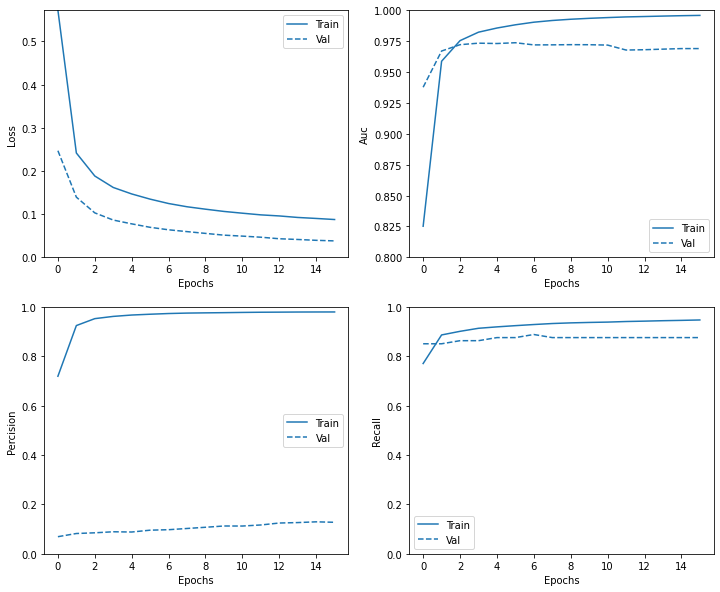

In [77]:
plot_metrics(resampled_history)

## Retrain

Because training is much easier on the balanced data, the above training procedure may overfit quickly.

In [78]:
resampled_model = build_model()
resampled_model.load_weights(filepath=initial_weights)

resampled_model.layers[-1].bias.assign([0.0])

resampled_history = resampled_model.fit(
  x = resampled_ds, 
  epochs = 10 * EPOCHS,
  steps_per_epoch = 20,
  callbacks=[early_stopping],
  validation_data=(val_ds)
)

Epoch 1/1000
20/20 [==============================] - 1s 67ms/step - loss: 1.8661 - tp: 5315.0000 - fp: 8492.0000 - tn: 57462.0000 - fn: 15260.0000 - accuracy: 0.7255 - percision: 0.3849 - recall: 0.2583 - auc: 0.6707 - val_loss: 0.5907 - val_tp: 13.0000 - val_fp: 14119.0000 - val_tn: 31370.0000 - val_fn: 67.0000 - val_accuracy: 0.6887 - val_percision: 9.1990e-04 - val_recall: 0.1625 - val_auc: 0.2805
Epoch 2/1000
20/20 [==============================] - 1s 26ms/step - loss: 1.0681 - tp: 10146.0000 - fp: 8414.0000 - tn: 11957.0000 - fn: 10443.0000 - accuracy: 0.5396 - percision: 0.5467 - recall: 0.4928 - auc: 0.5336 - val_loss: 0.6105 - val_tp: 63.0000 - val_fp: 15394.0000 - val_tn: 30095.0000 - val_fn: 17.0000 - val_accuracy: 0.6618 - val_percision: 0.0041 - val_recall: 0.7875 - val_auc: 0.8071
Epoch 3/1000
20/20 [==============================] - 1s 26ms/step - loss: 0.7058 - tp: 14344.0000 - fp: 8437.0000 - tn: 11983.0000 - fn: 6196.0000 - accuracy: 0.6427 - percision: 0.6296 - reca

## Re-Check the training history

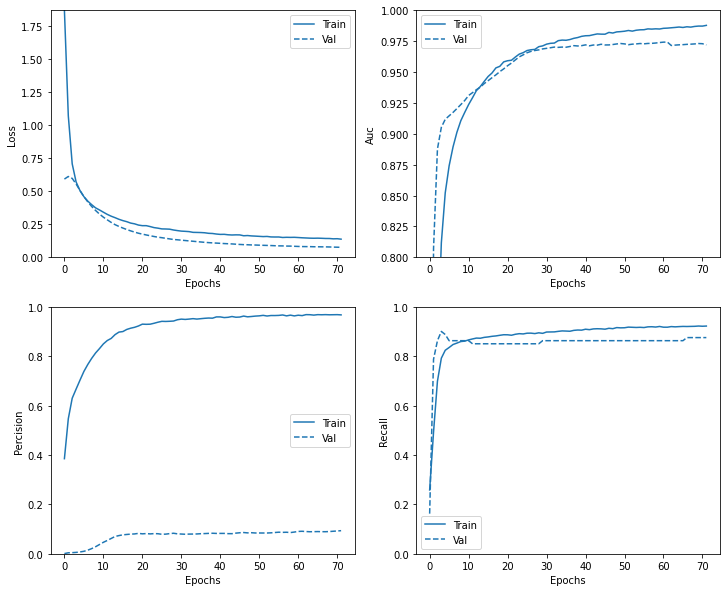

In [79]:
plot_metrics(resampled_history)

## Re-Evaluate the metrics

In [0]:
test_prediction_resampled = resampled_model.predict(x=test_features, batch_size=BATCH_SIZE)

In [81]:
resampled_result = resampled_model.evaluate(x=test_features, y=test_labels, batch_size=BATCH_SIZE)

for name, value in zip(resampled_model.metrics_names, resampled_result):
  print(name, ":", value)

28/28 [==============================] - 0s 6ms/step - loss: 0.0827 - tp: 88.0000 - fp: 894.0000 - tn: 55972.0000 - fn: 8.0000 - accuracy: 0.9842 - percision: 0.0896 - recall: 0.9167 - auc: 0.9948
loss : 0.0826992616057396
tp : 88.0
fp : 894.0
tn : 55972.0
fn : 8.0
accuracy : 0.9841648936271667
percision : 0.08961303532123566
recall : 0.9166666865348816
auc : 0.9947949647903442


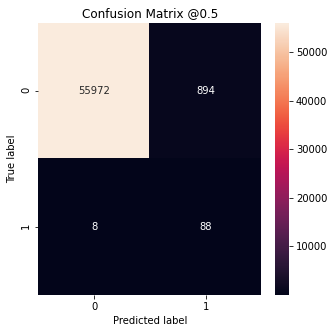

Legitimate Transactions Detected (True Negatives): 55972
Legitimate Transactions Incorrectly Detected (False Positives): 894
Fraudulent Transactions Missed (False Negatives): 8
Fraudulent Transactions Detected (True Positives): 88
Total Fraudulent Transactions: 96


In [82]:
plot_cm(labels=test_labels, predictions=test_prediction_resampled)

## Plot the ROC

In [0]:
train_predictions_resampled = resampled_model.predict(x=train_features, batch_size=BATCH_SIZE)

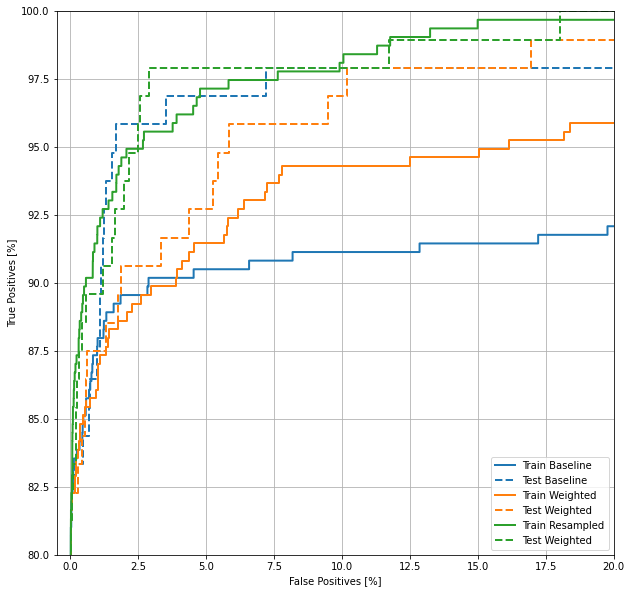

In [85]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, color=colors[0])
plot_roc('Test Baseline', test_labels, test_prediction_baseline, color=colors[0], linestyle='--')

plot_roc('Train Weighted', train_labels, train_predictions_weighted, color=colors[1])
plot_roc('Test Weighted', test_labels, test_prediction_weighted, color=colors[1], linestyle="--")

plot_roc('Train Resampled', train_labels, train_predictions_resampled, color=colors[2])
plot_roc('Test Weighted', test_labels, test_prediction_resampled, color=colors[2], linestyle="--")

plt.legend(loc='lower right')
plt.show()